In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import scipy.fftpack


Variable initialization

In [2]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [3]:
for i in range(M):    
    if i!= 0:
        DCT[:,i] = [np.sqrt(2/M)*np.cos(i*np.pi*(2*n+1)/(2*M)) for n in range(M)]
    else:
        DCT[:,i] = [np.sqrt(1/M)*np.cos(i*np.pi*(2*n+1)/(2*M)) for n in range(M)]


Generating the 1-D standard basis

In [4]:
for i in range(M):
    C[:, i] = [0]*M
    C[i, i] = 1


Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

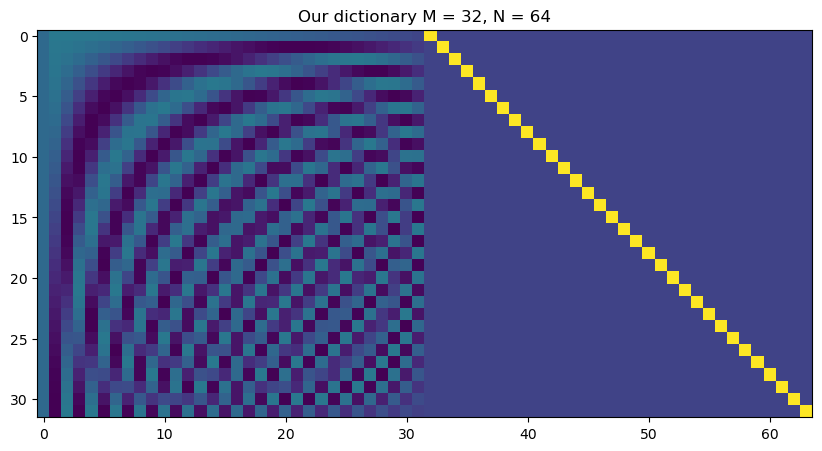

In [5]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $D$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [6]:
L = 4
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [7]:
x0 = [0]*N
rands = []
for i in range(L):
    r = np.random.randint(0, N)
    rands.append(r)
    x0[r] = np.random.randn()*sigma_noise

Choose spike location

In [8]:
spikeLocation = int(np.random.rand()*20)
x0[spikeLocation] = max(x0)*4

Synthetize the corresponding signal in the signal domain and add noise


In [9]:
s0 = np.dot(D, x0)
s =[ s0[i] + np.random.normal(0, 0.1) for i in range(M) ]
s = np.array(s, dtype='float32')

Plot the sparse signal

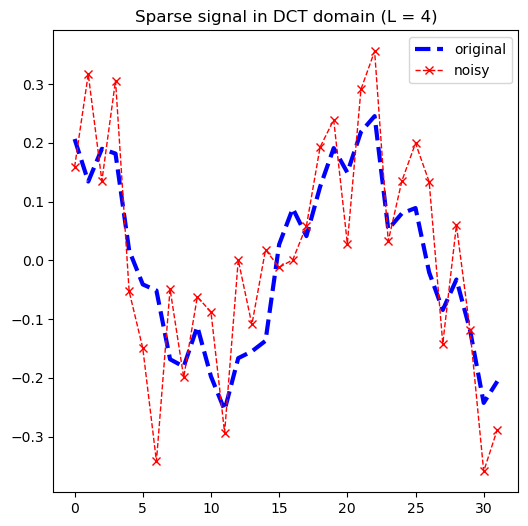

In [10]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Orthogonal Matching Pursuit
---------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [11]:
x_OMP = np.zeros(N)

# residual
r = s - np.dot(D, x_OMP)
resNorm = np.linalg.norm(r)

# support set
omega = []

MINIMUM_NORM_RES = 0.1

OMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [12]:
while np.count_nonzero(x_OMP) < L and resNorm > MINIMUM_NORM_RES: #STOPPING CRITERIA:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        zj = np.dot(r.T,D[:,j])/np.linalg.norm(D[:,j])**2
        e[j] = np.linalg.norm(r) - zj

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    x_OMP[omega] = np.dot(np.linalg.inv((D[:,omega].T @ D[:,omega])),D[:,omega].T @ s)

    # update the residual
    r = s - np.dot(D, x_OMP)


SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [13]:
s_hat_OMP = np.dot(D, x_OMP)

Show the result

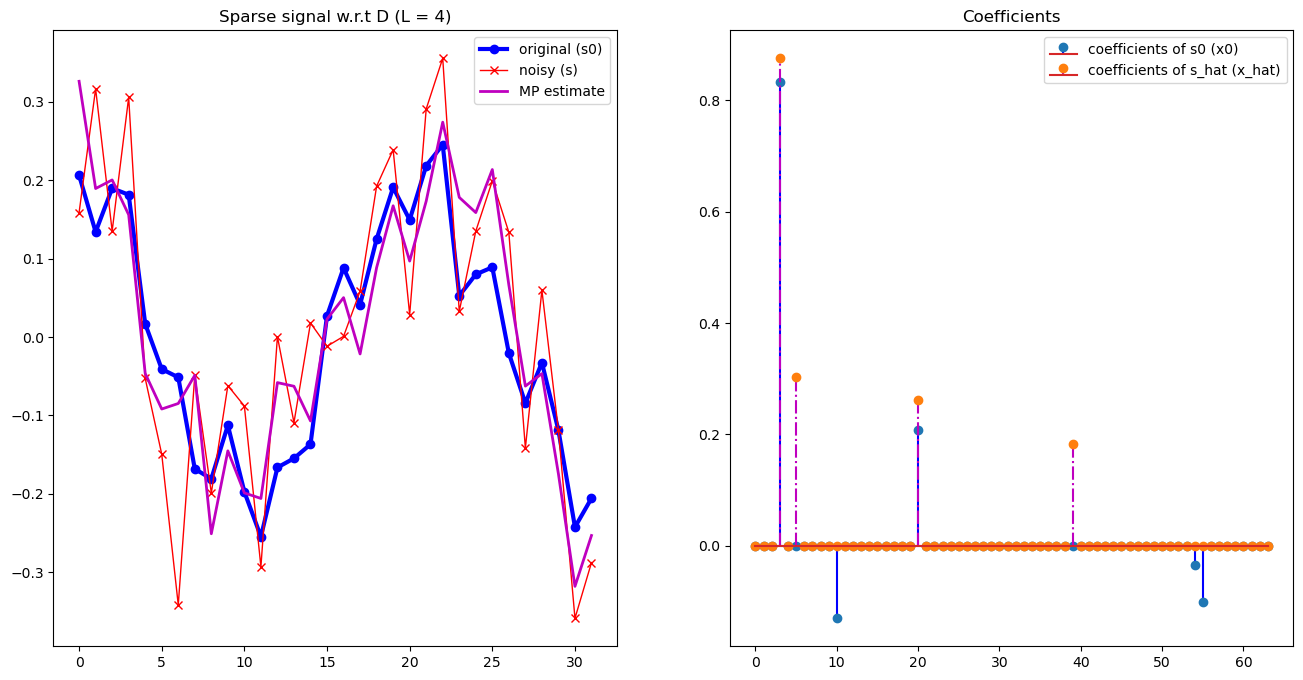

In [14]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_OMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_OMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

Least Squares Orthogonal Matching Pursuit
-----------------------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [15]:
x_LSOMP = np.zeros(N)

# residual
r = s - np.dot(D, x_OMP)
resNorm = np.linalg.norm(r)

# support set
omega = []

MINIMUM_NORM_RES = 0.1

LSOMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [16]:
while np.count_nonzero(x_LSOMP) < L: # STOPPING CRITERIA:
    # SWEEP STEP: find the best column by solving the LS problem
    if len(omega) == 0:
        # at the first iteration perform the usual sweep step
        e = np.zeros(N)
        for j in range(N):
            zj = np.dot(r.T,D[:,j])
            e[j] = np.linalg.norm(r) - zj
        # find the column of D that matches at best r, i.e. jStar = argmin(e(j))
        jStar = np.argmin(e)
        zjStar = np.dot(r.T,D[:,jStar])/np.linalg.norm(D[:,jStar])**2

        # UPDATE the support set with the jStar coefficient
        omega.append(jStar)

        # UPDATE the jStar coefficient by *summing* the new component dj' r^(i) / || dj ||^2
        x_LSOMP[jStar] += np.dot(zjStar,e[jStar])
    else:
        # perform the sweep step by solving the LS problem
        e= np.full(N,float('inf'))
        uzs = {}
        for j in range(N):
            if j not in omega:
                Dwdj = np.hstack((D[:,omega],D[:,j].reshape((M,1))))
                m1 = np.linalg.inv(Dwdj.T @ Dwdj)
                zwu = m1 @ Dwdj.T @ s
                e[j] = np.linalg.norm(s-(Dwdj @ zwu))**2      
                uzs[j] = zwu   
                

        # find the column of D that matches at best r, i.e. jStar = argmin(e(j))
        jStar = np.argmin(e)

        # UPDATE the support set with the jStar coefficient
        omega.append(jStar)
        # update the coefficients
        uz= uzs[jStar]
        x_LSOMP[omega] = uz
    # update the residual
    r = s - np.dot(D, x_LSOMP)



SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [17]:
s_hat_LSOMP = np.dot(D, x_LSOMP)

Show the result

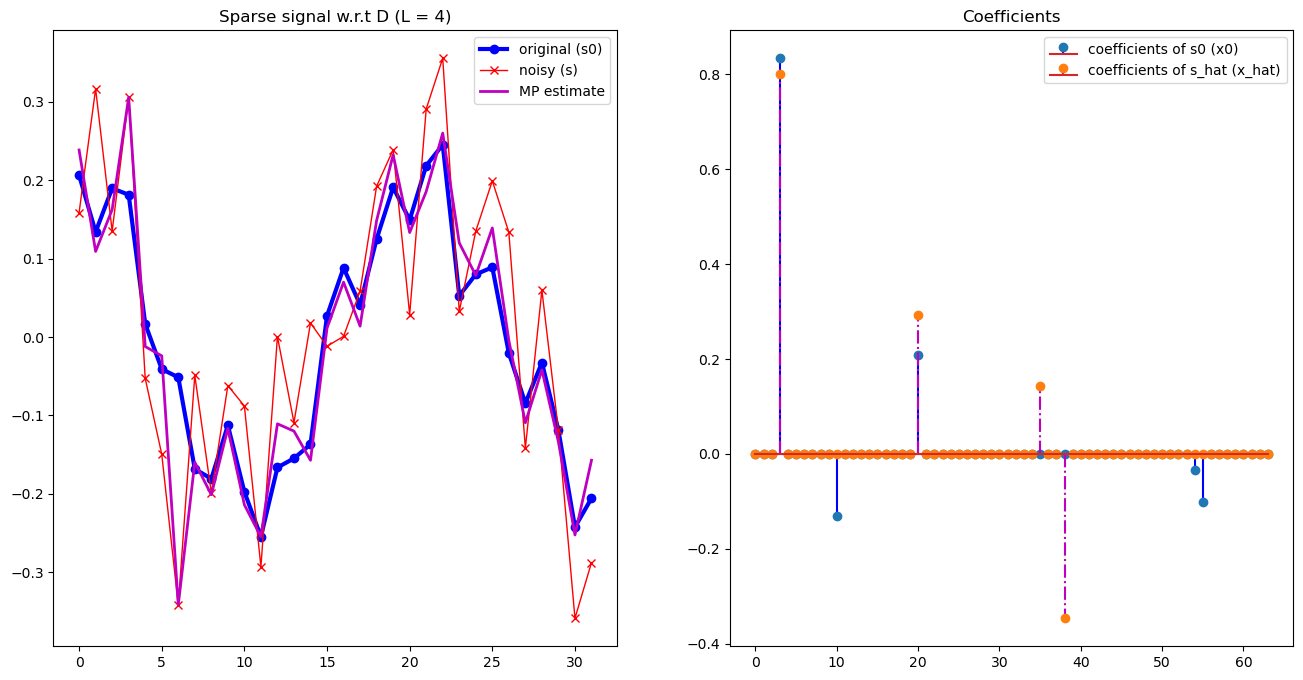

In [18]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_LSOMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_LSOMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])